# LSTM Time series (Keras/Tensorflow)

In [1]:
%load_ext autoreload
%autoreload 2
import os

import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from LSTM import *

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

figures saved to ../Figures/Modeling/LSTM


## Data exploration

In [26]:
files = os.listdir('../Datasets/fastStorage/2013-8')
files.sort()  # Short the files (compatible with mac)
files[519]

figures saved to ../Figures/Modeling/LSTM


'340.csv'

In [2]:
# Load data
VM = load_VM('917.csv')
# VM = load_VM('541.csv')
# Make it univariate
df = VM[['CPU usage [MHZ]']]
# df = VM

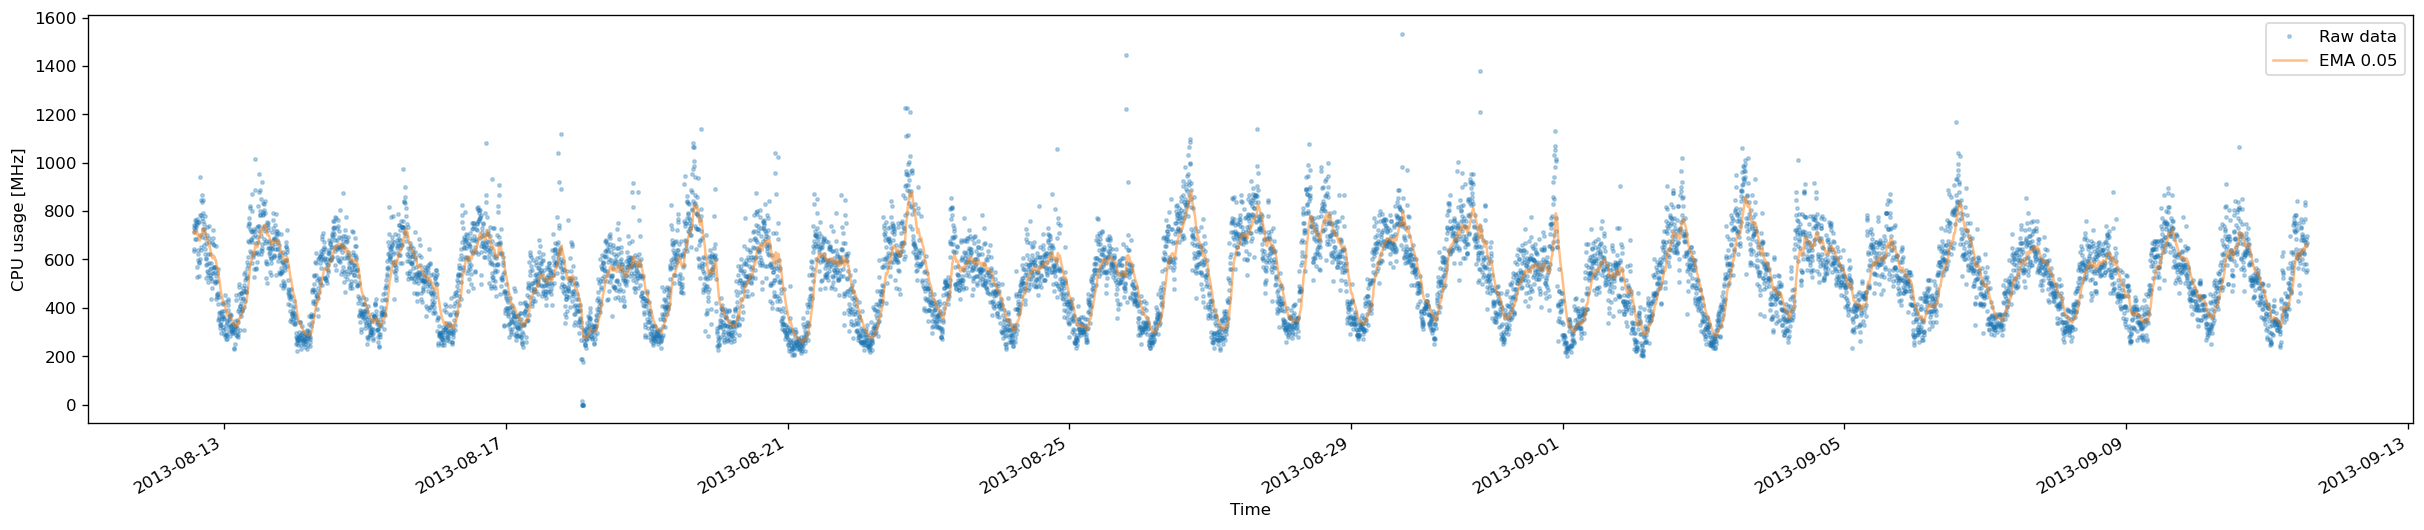

In [3]:
%matplotlib inline
plot_timeSeries(df['CPU usage [MHZ]'], ylabel='CPU usage [MHz]')

Metal device set to: Apple M1


2022-04-12 12:15:41.480630: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-12 12:15:41.480915: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


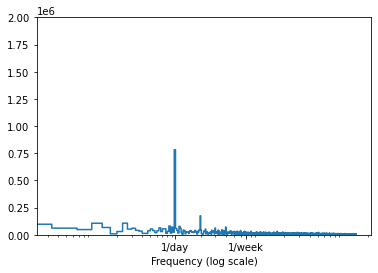

In [5]:
%matplotlib inline
fft = tf.signal.rfft(df['CPU usage [MHZ]'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(VM)
timestamps_per_day = 60*24/5
days_per_dataset = n_samples_h/ (timestamps_per_day)

f_per_day = f_per_dataset/days_per_dataset
plt.step(f_per_day, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 2000000)
# plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 7], labels=['1/day', '1/week'])
_ = plt.xlabel('Frequency (log scale)')

## Split the data

In [6]:
# (70%, 20%, 10%) split for the training, validation, and test sets
train_df, val_df, test_df = split_data(df)

## Normalizing the data

In [7]:
scaler = MinMaxScaler()
train_df, val_df, test_df = data_transformation(scaler, train_df, val_df, test_df)

## Cross modeling

In [4]:
VM_NUM_test = 340
# (80%, 20%, 0%) split for the training, validation from one VM
train_df, val_df, _ = split_data(df, 0.8, 0.19)
# Test set from other VM
VM_test = load_VM(f'{VM_NUM_test}.csv')
df_test = VM_test[['CPU usage [MHZ]']]

# Normalizing
# Train & Validation
scaler = MinMaxScaler()
train_df, val_df, _ = data_transformation(scaler, train_df, val_df, _)
# Test
scaler = MinMaxScaler()
df_test.loc[:, df_test.columns] = scaler.fit_transform(df_test.loc[:, df_test.columns])
test_df = df_test.copy()

/var/folders/mb/34bz2n2j38ldt4zjxtdpnfg80000gp/T/ipykernel_12043/2212480685.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, df_test.columns] = scaler.fit_transform(df_test.loc[:, df_test.columns])


## Adding daily info

In [8]:
df = add_daily_info(df)
# (70%, 20%, 10%) split for the training, validation, and test sets
train_df, val_df, test_df = split_data(df)

/Users/javier.galindos/Library/CloudStorage/OneDrive-FundaciónIMDEASoftware/Documents/Code/intern-project-javier/Modeling/LSTM.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
/Users/javier.galindos/Library/CloudStorage/OneDrive-FundaciónIMDEASoftware/Documents/Code/intern-project-javier/Modeling/LSTM.py:214: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
/Users/javier.galindos/Library/Cloud

Text(0.5, 1.0, 'Time of day signal')

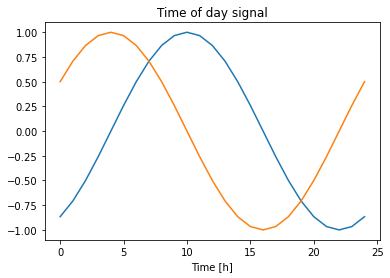

In [9]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

## LSTM

In [5]:
lstm_model = LstmModel(input_width=50,
                      label_width=16,
                      df=df,
                      name='917/CM_340',
                      train_df=train_df,
                      val_df=val_df,
                      test_df=test_df,
                      epoch=100,
                      units=20,
                      layers=1,
                      dropout=0,
                      )

2022-04-22 16:40:49.500236: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-22 16:40:49.500559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [9]:
# Magic func to use TensorBoard directly in IPython
%load_ext tensorboard

In [12]:
log_dir = f'logs/fit/{lstm_model.name}'
%tensorboard --logdir=logdir

Launching TensorBoard...

In [6]:
IPython.display.clear_output()
history = lstm_model.compile_and_fit(patience=50)

Input shape (batch, time, features): (427, 50, 1)
Labels shape (batch, time, features): (427, 16, 1)
Output shape:(427, 16, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 16)                336       
                                                                 
 reshape (Reshape)           (None, 16, 1)             0         
                                                                 
Total params: 2,096
Trainable params: 2,096
Non-trainable params: 0
_________________________________________________________________
Beginning training
Epoch 1/100


2022-04-22 16:41:03.532754: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-22 16:41:04.047805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-22 16:41:04.203348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-22 16:41:04.582229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 165ms/step - loss: 0.1293 - mean_absolute_error: 0.3416 - val_loss: 0.1154 - val_mean_absolute_error: 0.3268
Epoch 2/100
1/4 [======>.......................] - ETA: 0s - loss: 0.1207 - mean_absolute_error: 0.3312

2022-04-22 16:41:05.254360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-22 16:41:05.303897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 39ms/step - loss: 0.1219 - mean_absolute_error: 0.3312 - val_loss: 0.1073 - val_mean_absolute_error: 0.3145
Epoch 3/100
4/4 [==============================] - 0s 36ms/step - loss: 0.1127 - mean_absolute_error: 0.3175 - val_loss: 0.0966 - val_mean_absolute_error: 0.2975
Epoch 4/100
4/4 [==============================] - 0s 36ms/step - loss: 0.1006 - mean_absolute_error: 0.2985 - val_loss: 0.0821 - val_mean_absolute_error: 0.2728
Epoch 5/100
4/4 [==============================] - 0s 37ms/step - loss: 0.0839 - mean_absolute_error: 0.2702 - val_loss: 0.0626 - val_mean_absolute_error: 0.2351
Epoch 6/100
4/4 [==============================] - 0s 33ms/step - loss: 0.0621 - mean_absolute_error: 0.2272 - val_loss: 0.0389 - val_mean_absolute_error: 0.1782
Epoch 7/100
4/4 [==============================] - 0s 34ms/step - loss: 0.0374 - mean_absolute_error: 0.1650 - val_loss: 0.0172 - val_mean_absolute_error: 0.1060
Epoch 8/100
4/4 [=======================

In [7]:
IPython.display.clear_output()
pred = lstm_model.prediction(scaler)

Inference:


2022-04-22 16:42:05.837050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-22 16:42:05.870421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Inference time: 0.32 sec
4/4 [==============================] - 0s 57ms/step - loss: 0.0031 - mean_absolute_error: 0.0434


                                 0
MAE                     105.946266
MAPE                     33.782940
RMSE                    126.463654
MASE                      1.321687
train_time [s]           14.103026
inference_time [s]        0.322522
model_size [B]        22544.000000
IoU                       0.074504
DTW                  673848.451353
forecasting horizon      16.000000
               MAE          MAPE
count  8608.000000   8608.000000
mean    105.946273     33.782941
std      69.057924    171.407912
min       0.067420      0.010400
25%      55.168502     11.223397
50%     100.720017     23.824974
75%     147.710850     43.014277
max    1543.629617  12283.537105


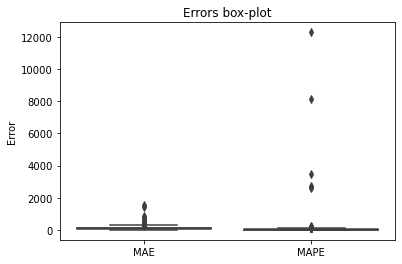

In [8]:
metrics = lstm_model.evaluation(pred,scaler)

In [27]:
val_mape = lstm_model.model.evaluate(lstm_model.window.val[0], lstm_model.window.val[1])

53/53 [==============================] - 1s 10ms/step - loss: 0.0021 - mean_absolute_error: 0.0347


In [12]:
# Figure
%matplotlib tk
test_trf = scaler.inverse_transform(test_df)
test_df_trf = pd.DataFrame(data=test_trf, columns=test_df.columns, index=test_df.index)
fig = plt.figure(dpi=150)
plt.grid()
test_df_trf['CPU usage [MHZ]'].plot(label='actual', color='k')
pred['CPU usage [MHZ]'].plot(label='forecast')
plt.ylabel('CPU usage [MHz]')
plt.title(f'Val MAPE:')
plt.grid()
plt.legend()
plt.show()

In [25]:
%matplotlib tk
defaultKwargs = {'marker': 'o',
                 'linestyle': '',
                 'alpha': 0.3,
                 'markersize': 2}
kwargs_forecast = {'marker': 'o',
                 'linestyle': '',
                 'alpha': 0.5,
                 'markersize': 2,
                  'color': 'tab:orange'}
fig = plt.figure(dpi=200)
plt.grid()
lstm_model.df['CPU usage [MHZ]'].plot(label='actual', color='k', **defaultKwargs)
pred['CPU usage [MHZ]'].plot(label='forecast', **kwargs_forecast)
plt.ylabel('CPU usage [MHz]')
plt.title(f'Val MAE:')
plt.grid()
plt.legend()
plt.show()

In [17]:
test_trf = scaler.inverse_transform(lstm_model.test_df)
test_df_trf = pd.DataFrame(data=test_trf, columns=lstm_model.test_df.columns, index=lstm_model.test_df.index)


In [26]:
fig = plt.figure(dpi=200)
plt.grid()
test_df_trf['CPU usage [MHZ]'].plot(label='actual', color='k', **defaultKwargs)
pred['CPU usage [MHZ]'].plot(label='forecast', **kwargs_forecast)
plt.ylabel('CPU usage [MHz]')
plt.title(f'Val MAE:')
plt.grid()
plt.legend()
plt.show()

## Closed loop predictions

In [48]:
fh = 9
pred = []

In [58]:
fh = 9
pred = []
for i in range(0,len(lstm_model.test_df), fh):
    input_data = lstm_model.test_pred[0][i].reshape((1,-1,1))
    for _ in range(fh):
        pred_next = lstm_model.model.predict(input_data, batch_size=lstm_model.batch_size)
        input_data = np.concatenate((np.reshape(input_data[:,1:,:],(-1,1)), pred_next))
        input_data = np.reshape(input_data, (1,-1,1))
        pred.append(pred_next)

In [60]:
pred = np.array(pred[:len(lstm_model.test_df)]).reshape((-1,1))

In [65]:
# Convert to dataframe
pred_df = pd.DataFrame(pred, columns=['CPU usage [MHZ]'])
pred_df.index = lstm_model.test_df.index
# Inverse transform
pred_trf = scaler.inverse_transform(pred_df)
pred_df_trf = pd.DataFrame(data=pred_trf, columns=['CPU usage [MHZ]'], index=lstm_model.test_df.index)

In [66]:
metrics = lstm_model.evaluation(pred_df_trf, scaler)

In [67]:
# Whole set
# Convert to dataframe
df_trf = scaler.inverse_transform(lstm_model.df)
df_df_trf = pd.DataFrame(data=df_trf, columns=lstm_model.df.columns, index=lstm_model.df.index)
# Test set
test_trf = scaler.inverse_transform(lstm_model.test_df)
test_df_trf = pd.DataFrame(data=test_trf, columns=lstm_model.test_df.columns, index=lstm_model.test_df.index)
val_mae = lstm_model.model.evaluate(lstm_model.val[0], lstm_model.val[1])

# Figure forecast
# Define default kwargs
defaultKwargs = {'marker': 'o',
                 'linestyle': '',
                 'alpha': 0.3,
                 'markersize': 2}
kwargs_forecast = {'marker': 'o',
                   'linestyle': '',
                   'alpha': 0.5,
                   'markersize': 2,
                   'color': 'tab:orange'}
fig = plt.figure(dpi=200)
plt.grid()
lstm_model.df['CPU usage [MHZ]'].plot(label='actual', color='k', **defaultKwargs)
pred_df_trf['CPU usage [MHZ]'].plot(label='forecast', **kwargs_forecast)
plt.ylabel('CPU usage [MHz]')
plt.title(f'Val MAE: {val_mae[1]:.3f}')
plt.grid()
plt.legend()
plt.show()

# Figure zoom
fig = plt.figure(dpi=200)
plt.grid()
test_df_trf['CPU usage [MHZ]'].plot(label='actual', color='k', **defaultKwargs)
pred_df_trf['CPU usage [MHZ]'].plot(label='forecast', **kwargs_forecast)
plt.ylabel('CPU usage [MHz]')
plt.title(f'Val MAE:{val_mae[1]:.3f}')
plt.grid()
plt.legend()
plt.show()

53/53 [==============================] - 1s 9ms/step - loss: 0.1558 - mean_absolute_error: 0.3016
